# Mach-Zehnder interferometers

*This tutorial is an extract from the Simphony docs. For further background reading, see the [Introduction to simphony](https://simphonyphotonics.readthedocs.io/en/latest/tutorials/intro.html)*

In this tutorial, we'll define and simulate a simple circuit known as a
Mach-Zender Interferometer (MZI).

The basic concept behind a Mach-Zehnder interferometer is that it splits a beam of light into two paths and then later recombines them. The resulting interference pattern depends on the relative path length, and therefore the accumulated phase, between the two paths. This is a very common device in quantum optics, and is used in many experiments.

Phase shifts may be caused by differing path lengths, or by the application of a phase shifter, such as a piezo-electric transducer.

Simphony uses [SAX](https://flaport.github.io/sax/index.html) to define 
models and simulate circuits, which uses 
[JAX](https://jax.readthedocs.io/en/latest/index.html) as a computational 
engine. JAX can provide a nice speedup for larger circuits if their models are 
appropriately defined and you have a GPU. Otherwise, it will run perfectly fine 
on a CPU.

:::{note}
We run the following command **first** to ensure that JAX, the library that allows Simphony and SAX to run calculations on GPU's, uses [double precision](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision). Be aware that this setting must be set before JAX initializes, or the setting won't take.
:::

In [1]:
from jax import config
config.update("jax_enable_x64", True)

In this tutorial, we'll use JAX as a drop in replacement for NumPy, matplotlib for visualizing our results, and SAX for constructing our circuit and running our simulations.

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax

## The MZI from it's components

In an MZI, light entering the circuit is split and travels down two paths of differing lengths. When the light is recombined, it interferes, and the output is frequency-dependent.

```{eval-rst}
.. figure:: ../images/mzi.png
    :alt: Mach-Zehnder Interferometer (MZI) layout.
    :align: center

    Chip layout of a Mach-Zehnder Interferometer (MZI).
```

The MZI we’ll create can be broken down into constituent parts. Simphony includes models for these building blocks below:

```{eval-rst}
.. figure:: ../images/mzi_outline_ports_marked.png
    :alt: Mach-Zehnder Interferometer (MZI) block diagram
    :align: center

    Block diagram of a Mach-Zehnder Interferometer (MZI) with the components labeled.
```

The grating couplers are the input and output for light in the circuit. The Y-branch can split and recombine light, and because the waveguides which carry light across the circuit have a different length relative to each other, this produces interference when the light is recombined at the second Y-branch. We can now begin defining our circuit in Simphony using the components we have identified.

## Models

We'll use models from the [SiEPIC Ebeam PDK](https://github.com/SiEPIC/SiEPIC_EBeam_PDK) library (already included in simphony).

In [3]:
from simphony.libraries import siepic

As explained in the Introduction, models in SAX (and therefore in Simphony) are simply "callables" (functions) that return a dictionary of scattering parameters. The keys of that resulting dictionary are the port-to-port relationships. In Simphony, we follow the convention ``(output, input)`` for the keys of the dictionary, which is the same as the S-parameter matrix formulation (where $S_{ij}$ is the scattering parameter representing the response at port $j$ given a stimuli at port $i$).

Models in SAX must have default parameters in their function signatures; that is, no positional arguments are allowed.

In [4]:
siepic.grating_coupler?

Signature:
siepic.grating_coupler(
    wl: Union[float, jax.Array] = 1.55,
    pol: Literal['te', 'tm'] = 'te',
    thickness: float = 220.0,
    dwidth: float = 0,
) -> Dict[Tuple[str, str], jaxtyping.Complex[Array, '...']]
Docstring:
SiEPIC EBeam PDK grating coupler optimized for TE polarizations at
1550nm.

The grating coupler efficiently couples light from a fiber array positioned
above the chip into the circuit. For the TE mode, the angle is -25 degrees
[needs citation].

.. image:: /_static/images/ebeam_gc_te1550.png
    :alt: ebeam_bdc_te1550.png

Parameters
----------
wl : float or Array
    The wavelengths to evaluate at in microns.
pol : {"te", "tm"}
    Polarization of the input/output modes.
thickness : {210.0, 220.0, 230.0}
    Thickness of the grating coupler silicon in nm. Useful for simulating
    manufacturing variability.
dwidth : {-20.0, 0.0, 20.0}
    Change in width from nominal of the gratings. Representative of
    manufacturing variability. Must be one of -20, 0

This means that they can always be called without arguments to inspect what their default return values are and to see what port names are provided.

In [5]:
siepic.grating_coupler()

{('o0', 'o0'): Array([-0.0307378-0.00345908j], dtype=complex128),
 ('o0', 'o1'): Array([0.75686856+0.02082852j], dtype=complex128),
 ('o1', 'o0'): Array([0.74360676+0.09760613j], dtype=complex128),
 ('o1', 'o1'): Array([0.0750638-0.02585451j], dtype=complex128)}

SAX also provides an explicit function to get the port names.

In [6]:
print(sax.get_ports(siepic.y_branch))
print(sax.get_ports(siepic.waveguide))
print(sax.get_ports(siepic.grating_coupler))

('port 1', 'port 2', 'port 3')
('o0', 'o1')
('o0', 'o1')


```{note}
Throughout all of Simphony and SAX, the ``"wl"`` argument is in microns, by convention. This is not strictly enforced, and
various model libraries may follow different convention, so it's always good to double check the documentation of the model you're using (or, if you're writing the model, create documentation for it)!
```

## Writing the netlist

A SAX circuit contains a 
netlist, which is a collection of component instances, their connections, and 
exposed ports; and a list of models, which makes it easy to swap out different
models without rewriting your netlist to see how the circuit behavior
changes.

The netlist is a dictionary with three fields:

* ``"instances"``: A dictionary of instance names to human-readable component 
    model strings (like "coupler" or "waveguide"). You will define the 
    string-to-model mapping later.
* ``"connections"``: A dictionary of ports to ports in the form 
    ``"instance_name,port_name": "instance_name,port_name"`` (note there is no
    whitespace delimiting the instance from its port, just a comma).
* ``"ports"``: Since a SAX circuit is basically a model itself, and could be
    used in other circuits, it has exposed ports. This field is a dictionary 
    mapping port names of the composite object to the ports of its constituent
    instances.

We'll create 

In [7]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            "gc_in": "gc",
            "splitter": "ybranch",
            "long_wg": "waveguide",
            "short_wg": "waveguide",
            "combiner": "ybranch",
            "gc_out": "gc",
        },
        "connections": {
            "gc_in,o0": "splitter,port 1",
            "splitter,port 2": "long_wg,o0",
            "splitter,port 3": "short_wg,o0",
            "long_wg,o1": "combiner,port 2",
            "short_wg,o1": "combiner,port 3",
            "combiner,port 1": "gc_out,o0",
        },
        "ports": {
            "in": "gc_in,o1",
            "out": "gc_out,o1",
        },
    },
    models={
        "ybranch": siepic.y_branch,
        "waveguide": siepic.waveguide,
        "gc": siepic.grating_coupler,
    }
)

## Simulation (using callables)

```{eval-rst}
:py:func:`sax.circuit` returns a tuple. The first element is another callable function. All
parameters you call it with will be passed on to the models contained within the
circuit, so long as they are named the same. In this way, a circuit itself can 
act as a model within another circuit.
```

```{warning}
It is important that your all models have **common names** for arguments. For example,
all models that take a ``length`` parameter should all use the name ``length`` for that argument. Models
that are wavelength dependent should all take the same ``wl`` keyword parameter (by 
convention). If you have your own model library, you can follow whatever 
convention you want, as long as it's consistent.
```

The second element of the returned tuple is a information object that contains details
about the circuit.

We can simulate the circuit by simply calling it with the appropriate arguments--in this case, the wavelengths we want to
simulate at.

The circuit itself contains parameterized models. We can pass arguments targeting
those models by passing a dictionary of keyword arguments and corresponding values
when invoking the circuit function. The names you gave the instances
in the netlist become the keyword arguments of the function. You can pass a 
dictionary which will be used to instantiate those components at simulation time.

If you're unsure of the format of the settings dictionary you need to pass to the circuit, you can use SAX's get_settings function.

In [8]:
sax.get_settings(mzi)

{'gc_in': {'wl': Array(1.55, dtype=float64),
  'pol': 'te',
  'thickness': Array(220., dtype=float64),
  'dwidth': Array(0., dtype=float64)},
 'splitter': {'wl': Array(1.55, dtype=float64),
  'pol': 'te',
  'thickness': Array(220., dtype=float64),
  'width': Array(500., dtype=float64)},
 'long_wg': {'wl': Array(1.55, dtype=float64),
  'pol': 'te',
  'length': Array(0., dtype=float64),
  'width': Array(500., dtype=float64),
  'height': Array(220., dtype=float64),
  'loss': Array(0., dtype=float64)},
 'short_wg': {'wl': Array(1.55, dtype=float64),
  'pol': 'te',
  'length': Array(0., dtype=float64),
  'width': Array(500., dtype=float64),
  'height': Array(220., dtype=float64),
  'loss': Array(0., dtype=float64)},
 'combiner': {'wl': Array(1.55, dtype=float64),
  'pol': 'te',
  'thickness': Array(220., dtype=float64),
  'width': Array(500., dtype=float64)},
 'gc_out': {'wl': Array(1.55, dtype=float64),
  'pol': 'te',
  'thickness': Array(220., dtype=float64),
  'dwidth': Array(0., dtype=f

This is slightly overkill in our case. We don't want to update ``wl`` for every single object. We only want to change the length parameters for the long and short waveguides, and let everything else stay with the default or assume a global value.

We can set the ``"long_wg"`` and ``"short_wg"`` waveguides to different lengths alone. The waveguide model within the circuit takes a "length" argument, so that's what we'll use in our dictionary of parameters that we pass using keyword arguments. These keyword arguments correspond to the *instance name* in the netlist. By setting ``wl`` at the toplevel, it will trickle down to all models that require a ``wl`` parameter.

In [9]:
wl = jnp.linspace(1.5, 1.6, 1000)
S = mzi(wl=wl, long_wg={"length": 150.0}, short_wg={"length": 50.0})

``S`` is now our evaluated s-parameter dictionary

We're interested in the power transmitted from the input to the output, which is the magnitude squared of the s-parameter. We'll square the magnitude of the ``"out,in"`` element of the resulting dictionary. Recall, too, that we renamed these "external" (unconnected) ports in the netlist when we created the circuit. It's really easy to give the ports on your composite circuits meaningful names, and it makes your code much more readable.

Below, we plot both in linear and in log scale using [``matplotlib``](https://matplotlib.org/).

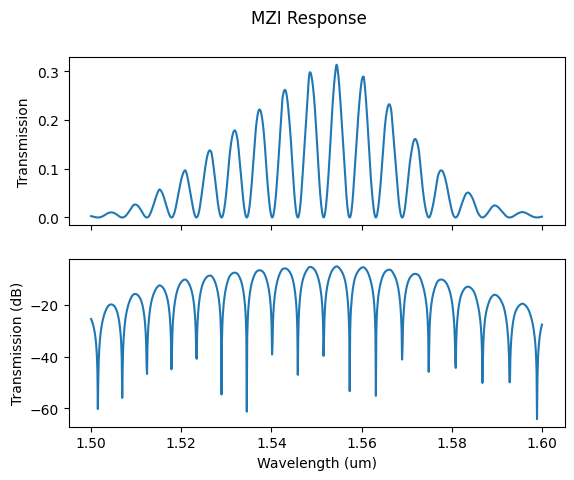

In [10]:
mag = jnp.abs(S["out", "in"])**2

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(wl, mag)
axs[0].set_ylabel("Transmission")
axs[1].plot(wl, 10*jnp.log10(mag))
axs[1].set_ylabel("Transmission (dB)")
axs[1].set_xlabel("Wavelength (um)")
plt.suptitle("MZI Response")
plt.show()

As you can see, and as you might have predicted, by varying the wavelength we can see different levels of power being output from the device. Notice how the power periodically dips to 0 (on the linear plot). This occurs when the phases of the two paths are exactly opposite, and the light destructively interferes. The power, however does not peak at a consistent maximum--an effect of using grating couplers, which are optimized for better coupling at some center wavelength (in this case, 1.55 microns).

## Analysis of a balanced MZI

You can think of a balanced interferometer as having equal path lengths when the light separates. In ideal conditions, this means that amount of power at the output is the same as the input. 

2024-01-09 23:00:01.222 | INFO     | gdsfactory.technology.layer_views:__init__:785 - Importing LayerViews from YAML file: '/home/sequoia/git/Photonics-Bootcamp/env/lib/python3.11/site-packages/gdsfactory/generic_tech/layer_views.yaml'.
2024-01-09 23:00:01.227 | INFO     | gdsfactory.pdk:activate:258 - 'generic' PDK is now active


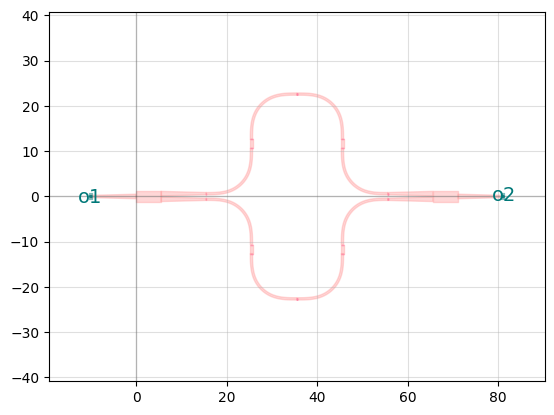

In [5]:
import gdsfactory as gf

PDK = gf.get_generic_pdk()
PDK.activate()

# The << is shorthand for c.add_ref()
c = gf.Component("my_component")
mzi = c << gf.components.mzi(delta_length=0)

c.plot_matplotlib()

There are there three different relevant amplitudes:
1. The amplitude of the input light:
$
    I_{input} = E_{input}^2
$

2. The amplitudes of the beams after the split
$
    E_{1} = \frac{E_{input}}{\sqrt{2}}, \hspace{2mm} E_{2} = \frac{E_{input}}{\sqrt{2}}
$

3. The amplitude of the recombined light
$
    I_{output} = [\frac{E_{1}+E_{2}}{\sqrt{2}}]^2 = I_{input}
$

```{warning} 
Note that these are not generalized equations. Instead, these describe a balanced interferometer whose branches have not undergone a phase shift.
```

### Quick check
If intensity of the input wave to a balanced interferometer is 0.5 mW, what is the intensity at the output? Assume lossless waveguides.

<details>
    <summary>Answer</summary>
    0.5 mW 
</details>

## Definitions

It would be helpful to mathematically model the light in our waveguides. We can start to build a model by considering the equation for a plane wave.

$$    
E = E_0 e^{i(\omega t - \beta z)}
$$

Propagation Constant of Light:
$
    \beta = \frac{2 \pi n}{\lambda} 
$

If the equations above describe the propogation of the wave before the light gets split by the MZI, we can represent the two resulting beams as follows.

$$
E_{o1} = \frac{E_{i}}{\sqrt{2}}e^{-i\beta_{1}L_{1}-\frac{\alpha_{1}}{2}L_{1}}
$$

$$
E_{o2} = \frac{E_{i}}{\sqrt{2}}e^{-i\beta_{2}L_{2}-\frac{\alpha_{2}}{2}L_{2}}
$$

*** As the light travels through the waveguide we can imagine that it will experience some degree of loss. The 'α' term that appeared in the exponents is the loss coefficient. For convenience, the following examples will assume that α = 0, or that there is zero loss in our waveguides.

And finally the intensity of the the recombined light at the end of the MZI can be described like so:

$$
I_{output} = \frac{I_{input}}{4} \lvert E_{o1} + E_{o2} \lvert ^2 
$$

## Analysis of imblanced MZI's

The equation below is the simplified version of the above expressions assuming no difference in the propogation constants of the two different waveguides and no loss.

$$
I_{output} = \frac{I_{input}}{2}(1 + cos(\beta \Delta L))
$$

2024-01-09 22:59:50.499 | INFO     | gdsfactory.technology.layer_views:__init__:785 - Importing LayerViews from YAML file: '/home/sequoia/git/Photonics-Bootcamp/env/lib/python3.11/site-packages/gdsfactory/generic_tech/layer_views.yaml'.
2024-01-09 22:59:50.508 | INFO     | gdsfactory.pdk:activate:258 - 'generic' PDK is now active


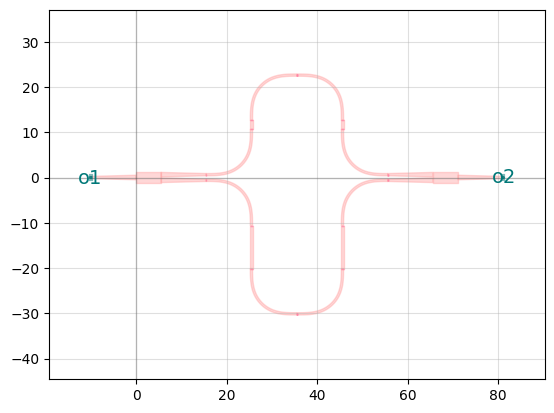

In [4]:
import gdsfactory as gf

PDK = gf.get_generic_pdk()
PDK.activate()

c = gf.Component("my_component")
mzi = c << gf.components.mzi(delta_length=15)

c.plot_matplotlib()

### Quick check

What is the intensity of the output light if the input light had an intensity of 0.75 mW and a refractive index through silicon of $n = 3.48$ when operating at a wavelength of 1450 nm? The shorter path has a length of 90 $\mu \text{m}$ and the longer path a length of 102 $\mu \text{m}$.

<details>
    <summary>Answer</summary>
    0.491 mW
</details>

## Thermo-optic effect

While a balanced MZI will not experience a phase shift due to a difference in path length, we can introduce a phasae shift by utilizing other methods. The thermo-optic effect describes the effect of heat on the phase of light. By heating up one of the waveguide in the MZI, we can control the phase shift of that waveguide and therefor the intensity of the output. This is a practical way to turn our otherwise static MZI in to a switch that we can control. 

![Image of a thermo-optic switch](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/thermo_optic_switch.png)

Introducing a phase shift in this way will affect the propogation constant 'β' and since we are assuming that the path lengths are equal, we can modify our previous equation like this:

$$
I_{output} = \frac{I_{input}}{2}(1 + cos(\Delta\beta L))
$$

### Quick check
Assume that the lengths of the two paths are 100µm, the light has a wavelength of 1500nm and the ouptput was measured to be 0.9mW. What is the input intensity of the MZI if the heater introduced a 90° phase shift in the top waveguide?
<details>
    <summary>Answer</summary>
    1.8 mW
</details>